In [1]:
from collections import deque
from tqdm.notebook import tqdm
import re
import torch
import numpy as np
import pandas as pd
import os
from pathlib import Path

data_path = Path('/home/scc/Downloads/playDataFeedback')

# 1- load & clean data

In [2]:
train_df = pd.read_csv(data_path.joinpath('train.csv'))
test_df = pd.read_csv(data_path.joinpath('test.csv'))
print(test_df.shape)

(10, 4)


In [3]:
train_df[train_df.essay_id == '00066EA9880D']

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
14340,fe6dfbd53216,00066EA9880D,Driverless cars are exaclty what you would exp...,Lead,Adequate
14341,ca9e1b60c9fb,00066EA9880D,The developement of these cars should be stopp...,Position,Effective
14342,6cf2157f4f19,00066EA9880D,the driver will be alerted when they will need...,Claim,Effective
14343,d920880f4341,00066EA9880D,This is such a dangerous thing because we all ...,Evidence,Effective
14344,7d52c3216a0e,00066EA9880D,Another thing that can go wrong with these car...,Claim,Effective
14345,30930de50889,00066EA9880D,Every person with any kind of technological de...,Evidence,Effective
14346,d16ff143cb0b,00066EA9880D,who to blame for the wreck if there were possi...,Claim,Effective
14347,cb665a65fb75,00066EA9880D,Should the manufacturer of the car be blamed o...,Evidence,Effective
14348,3e75ef7e0262,00066EA9880D,With all these things that could possibly go w...,Concluding Statement,Adequate


In [4]:
def basic_cleaning(text):
    """
    clear url/ not alpha/ fuck-bitch swear
    """
    text = re.sub(r'https?://www\.\S+\.cm', '', text)
    text = re.sub(r'[^a-zA-Z|\s]', '', text)
    text = re.sub(r'\*+', 'swear', text)
    return text

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    #emoticons
    #symbols & pictographs
    #transport & map symbols
    #flags (iOS)
    emoji_pattern = re.compile("["\
        u"\U0001F600-\U0001F64F|"\
        u"\U0001F300-\U0001F5FF|"\
        u"\U0001F680-\U0001F6FF|"\
        u"\U0001F1E0-\U0001F1FF|"\
        u"\U00002702-\U000027B0|"\
        u"\U000024C2-\U0001F251"\
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# remove repeated characters
def remove_multiplechars(text):
    """
    for example, so we have “way” instead of “waaaayyyyy”
    """
    text = re.sub(r'(.)\1{3,}', r'\1', text)
    return text

def clean(df):
    for col in ['discourse_text']:#,'selected_text']:
        df[col] = df[col].astype(str).apply(lambda x:basic_cleaning(x))
        df[col] = df[col].astype(str).apply(lambda x:remove_emoji(x))
        df[col] = df[col].astype(str).apply(lambda x:remove_html(x))
        df[col] = df[col].astype(str).apply(lambda x:remove_multiplechars(x))
    return df.sample(frac=1)

train_df = clean(train_df)
train_df_selection = train_df.sample(frac=1)
X_tr = train_df_selection.discourse_text.values

test_df = clean(test_df)
test_df_selection = test_df.sample(frac=1)
X_te = test_df_selection.discourse_text.values
print(X_te.shape)
print('clean Done')

(10,)
clean Done


In [5]:
y_tr1, uniques_tr1 = pd.factorize(train_df_selection.discourse_type, sort=True)
y_tr2, uniques_tr2 = pd.factorize(train_df_selection.discourse_effectiveness, sort=True)
print(uniques_tr1, uniques_tr2)

Index(['Claim', 'Concluding Statement', 'Counterclaim', 'Evidence', 'Lead',
       'Position', 'Rebuttal'],
      dtype='object') Index(['Adequate', 'Effective', 'Ineffective'], dtype='object')


# 2- Skip-Gram Embeding

## 2-1 embeding data generating

In [6]:
files_list = list(data_path.joinpath('train').iterdir()) +  list(data_path.joinpath('test').iterdir()) 

In [13]:
class dataGenerator(object):
    """
    https://arxiv.org/pdf/1310.4546.pdf
    """
    def __init__(self, file_list, min_count=5, min_random_unk_rate=0.2):
        self.min_count = min_count
        self.min_random_unk_rate = min_random_unk_rate
        self.stop_words = []
        self.word_count_sum = 0
        self.word_count = 0
        self.word2id = {}
        self.id2word = {}
        self.wordid_freq = {}
        self.word_freq = {}
        self.file_list = file_list
        self._init_dict()
        self.sample_table = self.__init_sample_table()
        self.drop_counts = 0


    def _init_dict(self):
        tq_bar = tqdm(enumerate(self.file_list))
        for idx, f_ in tq_bar:
            tq_bar.set_description(f'file_num={idx+1}')
            input_file = open(f_)
            for line in input_file:
                line_words = [i.lower() for i in basic_cleaning(line.strip()).split()]
                self.word_count_sum += len(line_words)
                for i, w in enumerate(line_words):
                    self.word_freq[w] = self.word_freq.get(w, 0) + 1
            tq_bar.update()
        
        v_arr = np.array(list(self.word_freq.values()))
        self.drop_counts = np.percentile(v_arr[v_arr>1], 99.95)
        tq_bar = tqdm(enumerate(self.file_list))
        for i, w in enumerate(self.word_freq):
            tq_bar.set_description(f'word:{i+1}')
            w_freq = self.word_freq[w]
            # for train & test OOV
            if (w_freq < self.min_count) and (np.random.random() < self.min_random_unk_rate):
                w = 'unk'
                w_freq += self.wordid_freq.get(self.word2id[w], 0) if w in self.word2id else 0
            if (w_freq < self.min_count) and (w != 'unk') :
                self.word_count_sum -= w_freq
                continue
            if w_freq >= self.drop_counts:
                self.word_count_sum -= w_freq
                self.stop_words.append(w)
                continue
            if (w == 'unk') and ('unk' in self.word2id):
                self.wordid_freq[self.word2id[w]] = w_freq
                continue

            self.word2id[w] = len(self.word2id)
            self.id2word[len(self.id2word)] = w
            self.wordid_freq[len(self.id2word) - 1] = w_freq
            tq_bar.update()
        self.word_count = len(self.word2id)
        
        

    def context2id(self, line_str, w2id=None):
        w2id = w2id if w2id is not None else self.word2id
        line = [i.lower() for i in basic_cleaning(line_str.strip()).split() if i not in self.stop_words]
        out = []
        for i in line:
            w_id = w2id.get(i, -1)
            # OOV
            if (w_id == -1) and (np.random.random() < self.min_random_unk_rate):
                w_id = w2id['unk']
            if w_id == -1:
                continue
            out.append(w_id)
        return out

    def file2id(self, file_name, w2id=None):
        w2id = w2id if w2id is not None else self.word2id
        input_file = open(file_name)
        out = []
        for line_str in input_file:
            out.extend(self.context2id(line_str, w2id))
        return out

    def __init_sample_table(self):
        wordid_freq = self.wordid_freq
        sample_table = []
        pow_freq = np.array(list(wordid_freq.values())) ** 0.78
        pow_freq_sum = np.sum(pow_freq)
        word_cnt = np.round(pow_freq / pow_freq_sum * 1e8)
        for idx, multi_times in enumerate(word_cnt):
            sample_table.extend([idx] * int(multi_times))
        return np.array(sample_table).flatten()

    def get_neg_samples(self, pos_pair, neg_cnt):
        return np.random.choice(self.sample_table, size=(len(pos_pair), neg_cnt)).tolist()

    def subsample(self, pos_pair):
        w_func = lambda x: max( 0, 1 - np.sqrt(10e-5/x) )
        drop_w = [w_func(self.wordid_freq[i[0]]/self.word_count_sum) for i in pos_pair]
        drop_bool = np.random.binomial(1, p=drop_w, size=len(drop_w)).astype(bool)
        return np.array(pos_pair)[~drop_bool].tolist()


# test_file_list = ['../input/feedback-prize-effectiveness/train/00066EA9880D.txt', 
# '../input/feedback-prize-effectiveness/train/000E6DE9E817.txt']
data_g = dataGenerator(files_list)
print('dataGenerator Done')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

dataGenerator Done


In [14]:
data_g.stop_words

['a', 'to', 'that', 'of', 'the', 'and', 'in', 'is']

In [15]:
def get_batch_pair(wordid_list, batch_size, window_size, idx, word_pair_queue):
    while len(word_pair_queue) < batch_size:
        if idx ==len(wordid_list):
            idx=0
        for _ in range(len(wordid_list)):
            for i in range(max(idx - window_size, 0), min(idx + window_size+1, len(wordid_list)-1)):
                w = wordid_list[idx]
                v = wordid_list[i]
                if idx == i:
                    continue
                word_pair_queue.append((w, v))
            idx += 1
        res_pair = []
        for _ in range(batch_size):
            res_pair.append(
                word_pair_queue.popleft()
            )
        return res_pair
    
def get_new_batch_pair(wordid_list, window_size):
    word_pair_queue = []
    for idx in range(len(wordid_list)):
        for i in range(max(idx - window_size, 0), min(idx + window_size+1, len(wordid_list)-1)):
            w = wordid_list[idx]
            v = wordid_list[i]
            if idx == i:
                continue
            if w == v:
                continue
            word_pair_queue.append((w, v))
    return word_pair_queue


wordid_list = data_g.file2id(files_list[20])
# pos_pair = get_batch_pair(wordid_list, batch_size=32, window_size=3, idx=0, word_pair_queue=deque())
pos_pair = get_new_batch_pair(wordid_list, window_size=5)
neg_ = data_g.get_neg_samples(pos_pair, 5)
print('get_neg_samples Done')

get_neg_samples Done


## 2-2 pytorch skip-gram model

In [66]:
import torch
from torch import nn
from torch.nn import functional as F
import typing as typ
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.optim import AdamW, Adam, SparseAdam, SGD
from sklearn.metrics import accuracy_score


class skpDataset(Dataset):
    def __init__(self, pos_w, pos_v, neg_v):
        self.pos_w = pos_w
        self.pos_v = pos_v
        self.neg_v = neg_v

    # 读取单个样本
    def __getitem__(self, idx):
        item = {}
        item['pos_w'] = torch.LongTensor([self.pos_w[idx]])
        item['pos_v'] = torch.LongTensor([self.pos_v[idx]])
        item['neg_v'] = torch.LongTensor([self.neg_v[idx].tolist()])
        return item
    
    def __len__(self):
        return len(self.pos_w)



class skipGramModel(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(skipGramModel, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.w_embed = nn.Embedding(vocab_size, embed_size, sparse=True)
        self.v_embed = nn.Embedding(vocab_size, embed_size, sparse=True)
        self._init_emb()
    
    def _init_emb(self):
        init_ = 0.5 / self.embed_size
        # 中心词矩阵
        self.w_embed.weight.data.uniform_(-init_, init_)
        # 周围词矩阵
        self.v_embed.weight.data.uniform_(-0, 0)


    def forward(self, pos_w, pos_v, neg_v):
        """_summary_
        目标是输出词向量, 所以foward可以直接输出loss便于backward
        Args:
            pos_w (_type_): 中心词
            pos_v (_type_): 周围词
            neg_v (_type_): 负采样  1个中心词对应n个负样本
        
        """
        # 中心词向量
        embed_w = self.w_embed(pos_w.squeeze(1) )
        # 周围词向量
        embed_v = self.v_embed(pos_v.squeeze(1) )
        neg_embed_v = self.v_embed(neg_v.squeeze(1) )
        # 元素相乘
        sc = torch.mul(embed_w, embed_v).sum(dim=1)
        sc = torch.clamp(sc, min=-10, max=10)
        sc = F.logsigmoid(sc)
        # bt * sample_num * emb_size   bt * embed_size * 1
        neg_sc = torch.bmm(neg_embed_v, embed_w.unsqueeze(2))
        neg_sc = torch.clamp(neg_sc, min=-10, max=10)
        neg_sc = F.logsigmoid(-1 * neg_sc)
        loss = -(torch.sum(sc) + torch.sum(neg_sc))
        return loss


    def save_embedding(self, id2word, filename):
        embed_1 = self.w_embed.weight.data.cpu().numpy()
        embed_2 = self.v_embed.weight.data.cpu().numpy()
        embed = (embed_1 + embed_2) / 2
        f = open(filename, 'w')
        for wid, w in id2word.items():
            e = embed[wid]
            e = ' '.join(map(lambda x:str(x), e))
            f.write(f'{w} {e}\n')

    def compile(self, 
            loss: typ.Callable,
            optimizer: typ.Callable,
            learning_rate: float,
            metrics: typ.List[typ.Callable],
            verbose: int=100):
        self.verbose = verbose
        b = torch.cuda.is_available()
        if(b):
            self.device = torch.device("cuda")
        else:
            self.device = torch.device("cpu")

        self.to(self.device)
        self.loss_fn = loss
        self.optim = optimizer(self.parameters(), lr=learning_rate)
        self.metrics = metrics
        self.iter_num = 0

    def _training_step(self, pos_w, pos_v, neg_v):
        pos_w = pos_w.to(self.device)
        pos_v = pos_v.to(self.device)
        neg_v = neg_v.to(self.device)
        self.epoch_steps += 1
        self.optim.zero_grad()
        loss =  self.forward(pos_w, pos_v, neg_v)
        self.epoch_loss += loss.detach().cpu().numpy()
        loss.backward()
        try:
            torch.nn.utils.clip_grad_norm_(self.parameters(), 1.0)
        except Exception as e:
            pass
        self.optim.step()
        self.iter_num += 1
        return self.epoch_loss, loss
    
    def train_one_epoch(self, dataloader, ep_idx=0):
        self.epoch_loss = 0
        self.epoch_samples = 0
        self.epoch_steps = 0
        tqdm_bar = tqdm(dataloader)
        for batch in tqdm_bar:
            loss, last_loss = self._training_step(batch['pos_w'], batch['pos_v'], batch['neg_v'])
            loss_p = loss/self.epoch_steps
            tqdm_bar.set_description(f'[ Train-Epoch {ep_idx+1} ]')
            tqdm_bar.set_postfix({"loss": f'{loss_p:.5f}', "last_loss" : f"{last_loss:.5f}"})
            tqdm_bar.update()
        print(f'[epoch - {ep_idx}] loss: {loss_p:.5f} last_loss:{last_loss:.5f}')
        
    def fit(self, pos_w, pos_v, neg_v,
            batch_size: int=32,
            epochs: int=5,
            ):
        for ep in range(epochs) :
            tr_data = skpDataset(pos_w, pos_v, neg_v)
            train_loader = DataLoader(tr_data, batch_size=batch_size, shuffle=True)
            self.train_one_epoch(train_loader, ep)

In [18]:
print(len(data_g.wordid_freq))
skp_model = skipGramModel(vocab_size=len(data_g.wordid_freq), embed_size=256)

7556


In [81]:
pos_pair = []
neg_ = []
for f in tqdm(files_list):
    wordid_list = data_g.file2id(f)
    tmp_pair = get_new_batch_pair(wordid_list, window_size=5)
    tmp_pair = data_g.subsample(tmp_pair)
    pos_pair.extend(tmp_pair)
    neg_.extend(data_g.get_neg_samples(tmp_pair,  5))
    
print('get_new_batch_pair Done')
pos_pair = np.array(pos_pair)

lr_ = 0.015 # 0.015 # 
print('--'*25, '\nlr:', lr_ )
skp_model.compile(
    loss=nn.CrossEntropyLoss(),
    optimizer=SparseAdam,
    learning_rate=lr_,
    metrics=[accuracy_score],
    verbose=100
)
skp_model.fit(pos_pair[:, 0], pos_pair[:, 1], np.array(neg_), batch_size=2048, epochs=5)
# [epoch - 4] loss: 10399.28735 last_loss:838.21423 0.03


  0%|          | 0/4192 [00:00<?, ?it/s]

get_new_batch_pair Done
-------------------------------------------------- 
lr: 0.01


  0%|          | 0/2393 [00:00<?, ?it/s]

[epoch - 0] loss: 9686.31045 last_loss:8475.85254


  0%|          | 0/2393 [00:00<?, ?it/s]

[epoch - 1] loss: 9636.58425 last_loss:8766.09863


  0%|          | 0/2393 [00:00<?, ?it/s]

[epoch - 2] loss: 9605.74703 last_loss:8140.20557


  0%|          | 0/2393 [00:00<?, ?it/s]

[epoch - 3] loss: 9585.81670 last_loss:8515.24902


  0%|          | 0/2393 [00:00<?, ?it/s]

[epoch - 4] loss: 9566.89738 last_loss:8538.35156


# valuate

In [75]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_embs(emb, words, words2ids_dict):
    for w in words:
        w_emb = emb[words2ids_dict[w]]
        plt.scatter(w_emb[0], w_emb[1])
        plt.text(w_emb[0], w_emb[1], w)
    
    plt.show()


def sp_plot_emb(emb, similar_pair1, similar_pair2, words2ids_dict):
    s1_a = emb[words2ids_dict[similar_pair1[0]]]
    s1_b = emb[words2ids_dict[similar_pair1[1]]]
    plt.scatter(s1_a[0], s1_a[1])
    plt.text(s1_a[0], s1_a[1], similar_pair1[0])
    plt.scatter(s1_b[0], s1_b[1])
    plt.text(s1_b[0], s1_b[1], similar_pair1[1])

    s1_attr = s1_a - s1_b
    attr1=f'{similar_pair1[0]}-{similar_pair1[1]}'
    s2_a = emb[words2ids_dict[similar_pair2[0]]]
    s2_b = emb[words2ids_dict[similar_pair2[1]]]
    plt.scatter(s2_a[0], s2_a[1])
    plt.text(s2_a[0], s2_a[1], similar_pair2[0])
    plt.scatter(s2_b[0], s2_b[1])
    plt.text(s2_b[0], s2_b[1], similar_pair2[1])
    s2_attr = s2_a - s2_b
    attr2=f'{similar_pair2[0]}-{similar_pair2[1]}'

    s2_b_add_attr = s2_b + s1_attr
    plt.scatter(s2_b_add_attr[0], s2_b_add_attr[1])
    plt.text(s2_b_add_attr[0], s2_b_add_attr[1], similar_pair2[1] + f' + {attr1}')

    s1_b_add_attr = s1_b + s2_attr
    plt.scatter(s1_b_add_attr[0], s1_b_add_attr[1])
    plt.text(s1_b_add_attr[0], s1_b_add_attr[1], similar_pair1[1] + f' + {attr2}')
    plt.show()

In [76]:
data_g.word2id['man'], data_g.word2id['king'], data_g.word2id['woman'], data_g.word2id['father'], data_g.word2id['mother']

(1619, 4463, 793, 4517, 1359)

In [77]:
from sklearn.manifold import TSNE

embed_1 = skp_model.w_embed.weight.data.cpu().numpy()
embed_2 = skp_model.v_embed.weight.data.cpu().numpy()
embed = (embed_1 + embed_2) / 2

embed_dim2 = TSNE(n_components=2).fit_transform(embed)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f6a42018e50>
Traceback (most recent call last):
  File "/home/scc/anaconda3/envs/sccRL/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/scc/anaconda3/envs/sccRL/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/scc/anaconda3/envs/sccRL/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/scc/anaconda3/envs/sccRL/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


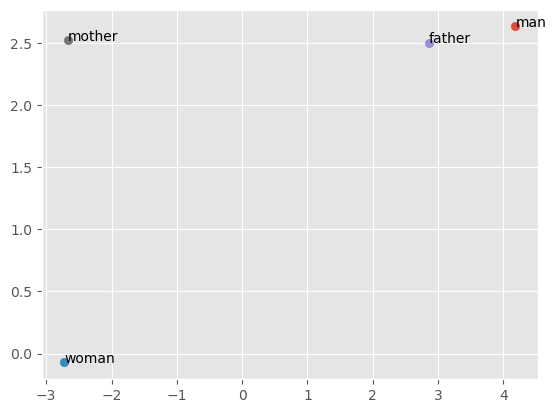

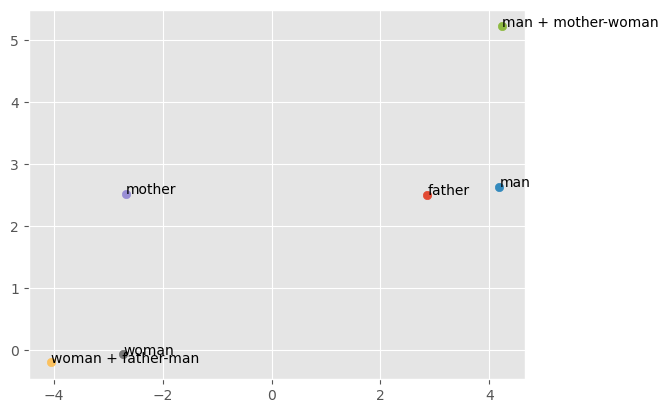

In [78]:
plot_embs(embed_dim2, ['man', 'woman', 'father', 'mother'], data_g.word2id)

sp_plot_emb(embed_dim2, ['father', 'man'], ['mother', 'woman'], data_g.word2id)